In [ ]:
#Required packages:
#PyPolyaGamma
!pip install PyPolyaGamma

In [2]:
#Standard packages:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
from math import *
import numpy as np
import numpy.random as rd
import scipy.stats as stat
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal
from pypolyagamma import logistic, PyPolyaGamma

#Figure configuration:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# EXAMPLE 1: Bayesian logistic regression


Bayesian logistic regression model is a Bayesian version of the popular logistic regression model. We assume a Gaussian prior on regression coefficients.
Then, the working model is
\begin{align*}
Y(i) \mid X(i) \,,\, \beta &\sim
\mathrm{Bernoulli}(\sigma(X(i)\beta) )\,\, (i=1,\ldots,n),
\\
\beta &\sim \mathrm{Normal}(0,I),
\end{align*}
where $\sigma(x)=1/\{1+\exp(-x)\}$.

We compare
- Posterior mean of $\beta$
- Logistic ridge regression
\begin{align*}
\textrm{argmax}_{\beta} \left\{\sum_{i=1}^{n} l(y(i),x(i)\,;\,\beta)  - \frac{\|\beta\|^{2}}{2}\right\}
\end{align*}
with $l(y(i),x(i)\,;\,\beta):=y(i)\log \sigma(x(i)\beta)+(1-y(i))\log \{1-\sigma(x(i)\beta)\}$.
- MAP estimate of $\beta$ using matching prior pair of Gaussian prior
\begin{align*}
\textrm{argmax}_{\beta} \left\{\sum_{i=1}^{n} l(y(i),x(i)\,;\,\beta)  - \frac{1}{2}\|\beta\|^{2} - \frac{1}{2}\log \left| \sum_{i=1}^{n}(X(i))^{\top}X(i)\left[\sigma(X(i)\beta)\{1-\sigma(X(i)\beta)\}\right] \right|\right\}.
\end{align*}


The comparison utilizes the banknote authentication data
from UCI Machine Learning Repository.

In [3]:
#Conducting MCMC using Polya-Gamma augumentation
def baylogit(Xs,Ys,pos_samples = 20000,thinning    = 10,burnin      = 10000, beta_sigma2=1):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #pos_samples: number of posterior samples
      #thinning: set-up of thinning
      #burinin: set-up of burinin period
      #beta_sigma2: set-up of prior variance
  #Output:
      #Posterior samples of beta
    pg = PyPolyaGamma(seed=0)
    n   = Ys.shape[0]
    dim = Xs.shape[1]
    omegas = np.ones((n,pos_samples))
    betas = np.ones((dim, pos_samples))
    for i in range(1, pos_samples):
        omegas[:,i] = [pg.pgdraw(1, Xs[s,:].dot(betas[:,i-1])) for s in range(n)]
        V_omega = np.linalg.inv( Xs.T @ np.diag(omegas[:,i]) @ Xs+ (1/beta_sigma2)*np.eye(dim) )
        mu_omega = V_omega @ (Xs.T @ (Ys-1/2))
        betas[:,i] = multivariate_normal.rvs(
        mean=mu_omega[:],
        cov=V_omega,
        size=1)
    final_betas = betas[:,range(burnin,pos_samples,thinning)]
    return final_betas

#Sigmoid function
def sigmoid(x):
 return 1/(1 + np.exp(-x))


#Conducting logistic ridge regression
def calc_penalizedlogistic(Ys,Xs,init):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #init: initial values for optimization
  #Output:
      #logistic ridge regression estimate
  def minusobs(beta):
    dim = Xs.shape[1]
    n   = Ys.shape[0]
    loglikelihood_vec = np.array([ Ys[i]*np.log( sigmoid(Xs[i,:].dot(beta)) ) + (1-Ys[i])*np.log(1-sigmoid(Xs[i,:].dot(beta))) for i in range(n)])
    logprior_vec      = np.array([ (-1)*np.sum(beta**2)/(2*n) for i in range(n)])
    return (-1)*(np.sum(loglikelihood_vec)+np.sum(logprior_vec))
  dim=len(init)
  MAP = opt.minimize(fun=minusobs,x0=init)
  return MAP.x


#Conducting MAP using mathcing prior pair of Gaussian prior
def calc_modifiedpenalizedlogistic(Ys,Xs,init):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #init: initial values for optimization
  #Output:
      #MAP using mathcing prior pair of Gaussian prior
  def minusobs(beta):
    dim = Xs.shape[1]
    n   = Ys.shape[0]
    loglikelihood_vec = np.array([ Ys[i]*np.log( sigmoid(Xs[i,:].dot(beta)) ) + (1-Ys[i])*np.log(1-sigmoid(Xs[i,:].dot(beta))) for i in range(n)])
    logGauss_vec      = np.array([ (-1)*np.sum(beta**2)/(2*n) for i in range(n)])
    Fisher_vec        = np.array([ np.matmul(Xs[i,:].reshape((1,dim)).T, Xs[i,:].reshape((1,dim))) * sigmoid(Xs[i,:].dot(beta))*(1-sigmoid(Xs[i,:].dot(beta))) for i in range(n)])
    return (-1)*(np.sum(loglikelihood_vec)+np.sum(logGauss_vec)-(1/2)*np.linalg.slogdet(np.mean(Fisher_vec,axis=0))[1])
  dim=len(init)
  MAP = opt.minimize(fun=minusobs,x0=init)
  return MAP.x

In [4]:
#Preparation for data
df_banknote = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt",header=None)
df_banknote.columns = ["Variance","Skewness","Curtosis","Entropy","Class"]
n_max_bank=df_banknote.shape[0]

Ys_bank=df_banknote["Class"].to_numpy()
Xs_bank=df_banknote[["Variance","Skewness","Curtosis","Entropy"]].to_numpy()

#MCMC, logistic ridge regression, MAP using mathcing prior pair of Gaussian prior
pos_bank=baylogit(Xs=Xs_bank,Ys=Ys_bank,pos_samples = 20000,thinning    = 1,burnin      = 10000, beta_sigma2=1)
MAP_bank=calc_penalizedlogistic(Ys=Ys_bank,Xs=Xs_bank,init=pos_bank.mean(axis=1))
modifMAP_bank=calc_modifiedpenalizedlogistic(Ys=Ys_bank,Xs=Xs_bank,init=pos_bank.mean(axis=1))

Text(0, 0.5, '|MAP - Posterior means|')

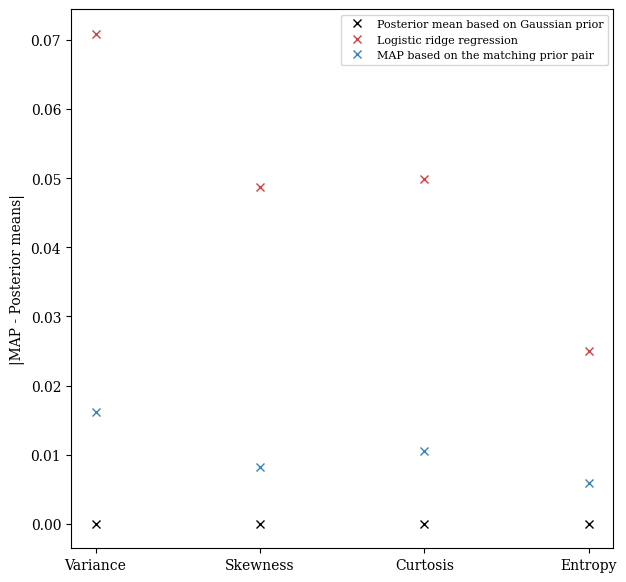

In [5]:
#Display estimates
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
ax.plot([0,1,2,3],abs(pos_bank.mean(axis=1)-pos_bank.mean(axis=1)),"x",color="black",label="Posterior mean based on Gaussian prior")
ax.plot([0,1,2,3],abs(MAP_bank-pos_bank.mean(axis=1)),"x",color="tab:red",alpha=0.9,label="Logistic ridge regression")
ax.plot([0,1,2,3],abs(modifMAP_bank-pos_bank.mean(axis=1)),"x",color="tab:blue",alpha=0.9,label="MAP based on the matching prior pair")
ax.legend(loc="upper right",prop={'size':8})
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["Variance","Skewness","Curtosis","Entropy"])
ax.set_ylabel("|MAP - Posterior means|")

# EXAMPLE 2: Poisson shrinkage models

Poisson sequence model is a gold-standard starting point of count-data analysis.
Here we investigate the calibration in high-dimension based on the matching prior pair of the improper shrinkage prior proposed by Komaki (2006):
\begin{align*}
Y(i) =(Y_{1}(i),\ldots, Y_{d}(i))\mid \lambda=(\lambda_{1},\ldots,\lambda_{d}) &\sim \otimes_{i=1}^{d} \mathrm{Poisson}(\lambda_{i}) \,\, (i=1,\ldots,n),\\
\pi(\lambda)&= \frac{\lambda_{1}^{\beta_{1}-1}\cdots\lambda_{d}^{\beta_{d}-1}}{(\lambda_{1}+\cdots+\lambda_{d})^{\alpha}},
\end{align*}


Sampling from Komaki's shrinkage prior for Poisson models is as follows:

*   Model:
$X_{i} \sim Po(r \lambda_i ),\,i=1,\ldots,d$ where $r$ is the sample size.


*   Prior:
$\pi_{\alpha,\beta}(\lambda)=\frac{\lambda_{1}^{\beta_{1}-1}\cdots\lambda_{d}^{\beta_{d}-1}}{(\lambda_{1}+\cdots+\lambda_{d})^\alpha}$

*  Posterior:
$\pi_{\alpha,\beta}(\lambda \mid x)\propto \left\{\prod_{i=1}^{d} \left(\frac{\lambda_{i}}{\|\lambda\|_{1}}\right)^{x_{i}+\beta_{i}-1}\right\} \left\{\|\lambda\|_{1}^{\sum_{i}(x_{i}+\beta_{i}-1)-\alpha}e^{-r\|\lambda\|_{1}}
\right\}$

* Change of variables $(\lambda_{1},\ldots,\lambda_{d}) \to (w_{1}=\lambda_{1}/\|\lambda\|_{1},\ldots,w_{d}=\lambda_{d}/\|\lambda\|_{1}, \mu=\|\lambda\|_{1})$

> * Jacobian: $\mu^{d-1}dw_{1}\ldots d w_{d-1}d\mu=d\lambda_{1}\ldots d\lambda_{d}$

> * Posterior: $\pi_{\alpha,\beta}(w,\mu \mid x)\propto \left\{\prod_{i=1}^{d} w_{i}^{x_{i}+\beta_{i}-1}\right\} \left\{\mu^{\sum_{i}(x_{i}+\beta_{i})-d-\alpha}e^{-r\mu}
\right\}\mu^{d-1} = \left\{\prod_{i=1}^{d} w_{i}^{x_{i}+\beta_{i}-1}\right\} \left\{\mu^{\sum_{i}(x_{i}+\beta_{i})-\alpha-1}e^{-r\mu}
\right\}$

*  Exact sampling from the posterior:

  1. First sample $\mu:=\|\lambda\|_{1}$ from $\mathrm{Gamma}(\mathrm{shape}=\sum(x_{i}+\beta_{i})-\alpha,\,\mathrm{scale}=1/r)$
  2. Then sample $(w_1,\ldots,w_d)$ from $\mathrm{Dirichlet}(x_1 + \beta_1 ,\ldots,x_d+\beta_d)$
  3. Output $\lambda_1=w_1 \mu,\ldots,\lambda_d=w_d \mu$


In this example, we employ synthetic data to compare MAP estimate based on Komaki's improper prior; posterior mean of the same prior; and posterior mean based on the matching prior pair.

In [ ]:

#Calculating MAP estimate with hyperparameter beta and alpha

def calc_MAP(X,init,hyperparam_beta,hyperparam_alpha):
  #Input:
      #X: observations (n times d)
      #beta: dim-dimensional array
      #alpha: scalar
      #init: initial value for optimization
  #Output:
      #MAP estimate
  def minus_log_pos(lam):
    dim = len(lam)
    r  = X.shape[0]
    loglikelihood_vec = np.array([X.sum(axis=0)[i]*np.log(lam[i])-r*lam[i] for i in range(dim)])
    logprior_vec      = np.array([ (hyperparam_beta[i]-1)* np.log(lam[i]) - (hyperparam_alpha/dim)*np.log(sum(lam)) for i in range(dim)])
    return (-1)*(sum(loglikelihood_vec)+sum(logprior_vec))
  dim=len(init)
  MAP = opt.minimize(minus_log_pos,init,bounds = tuple([(0.0001,np.inf) for i in range(dim)]))
  return MAP.x


#Conducting MCMC with hyperparameter beta and alpha

def possample_K04(X,hyperparam_beta,hyperparam_alpha,pos_num):
  #Input:
      #X: observations (n times d)
      #beta: dim-dimensional array
      #alpha: scalar
      #init: initial value for optimization
      #pos_num: int. for num of posterior samples
  #Output:
      #(posterior samples of mu, posterior samples of w, posterior samples of lambda)
  dim = X.shape[1]
  r   = X.shape[0]
  shape = X.sum()+hyperparam_beta.sum()-hyperparam_alpha
  scale = 1/r
  pos_lam_length = np.random.gamma(shape=shape,scale=scale,size=pos_num)
  alpha = X.sum(axis=0)+hyperparam_beta
  pos_w          = np.random.dirichlet(alpha=alpha,size=pos_num)
  return pos_lam_length, pos_w , np.array([ pos_lam_length[i]* pos_w[i] for i in range(pos_num)])

In [ ]:
#======================================================================
# Create synthetic data
# X's shape (N, dim)
dim =  100
N   =   10
pos_sample=10000
lam_true = np.array([0.001 if (i % 2 == 0) else 2 for i in range(dim)])
X = np.array([np.random.poisson(lam=lam_true) for n in range(N)])


#======================================================================
# Matching prior pair construction

hyperparam_beta  = 3*np.ones(dim)
hyperparam_alpha = sum(hyperparam_beta)-1

adjusted_beta  = hyperparam_beta-1.
adjusted_alpha = hyperparam_alpha

#======================================================================
# adust means posterior samples based on the matching prior pair
# nonadust means posterior samples based on the initial prior

MAP=calc_MAP(X,lam_true,hyperparam_beta,hyperparam_alpha)
pos_lam_adjust=possample_K04(X=X,hyperparam_beta=adjusted_beta ,hyperparam_alpha=adjusted_alpha,pos_num=pos_sample)[2]
pos_lam_nonadjust=possample_K04(X=X,hyperparam_beta=hyperparam_beta,hyperparam_alpha=hyperparam_alpha,pos_num=pos_sample)[2]

Text(0.5, 0, 'Dimension')

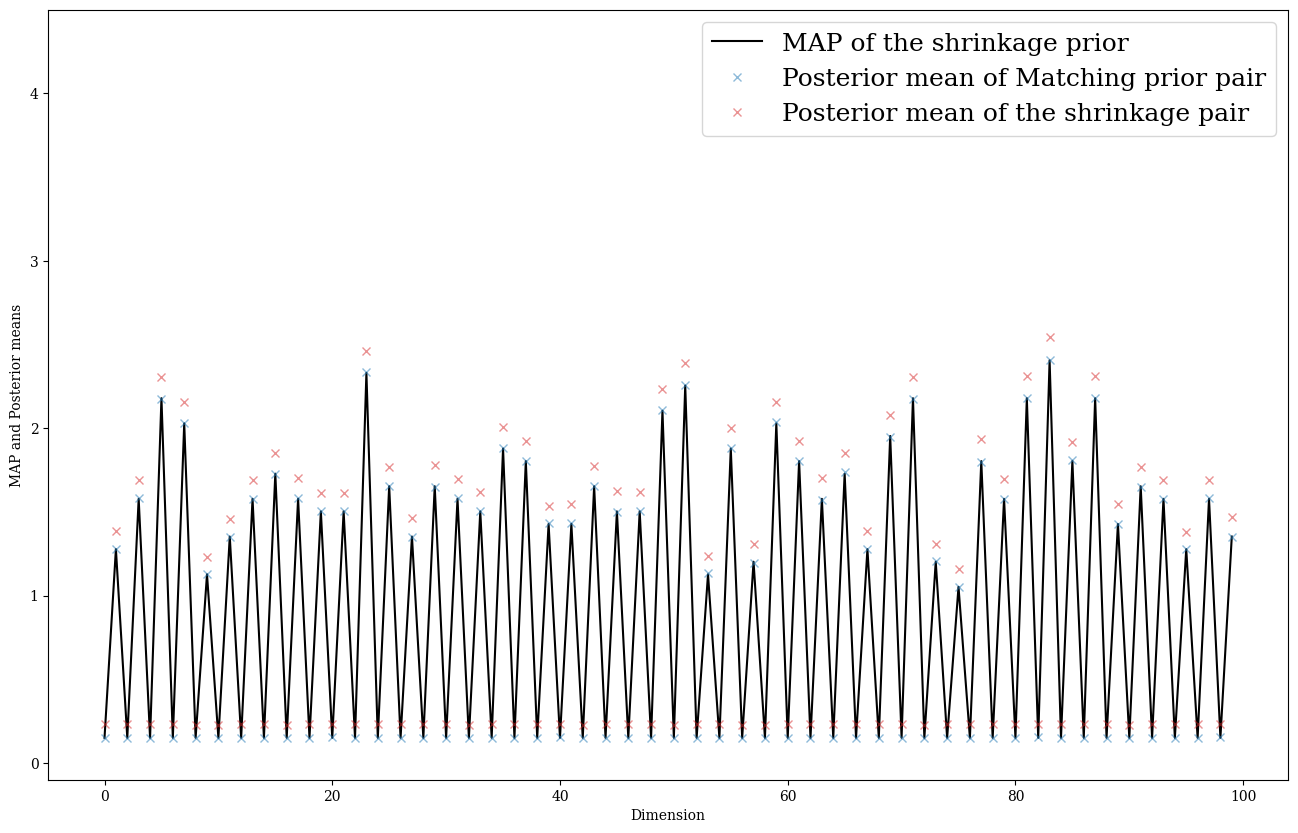

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.4)


ax.plot(MAP,color="black",label="MAP of the shrinkage prior")
ax.plot(pos_lam_adjust.mean(axis=0),"x",color="tab:blue",alpha=0.5,label="Posterior mean of Matching prior pair")
ax.plot(pos_lam_nonadjust.mean(axis=0),"x",color="tab:red",alpha=0.5,label="Posterior mean of the shrinkage pair")
ax.set_ylim(-0.1,4.5)
ax.legend(loc="upper right",prop={'size':18})
ax.set_ylabel("MAP and Posterior means")
ax.set_xlabel("Dimension")